In [1]:
##### Importing Relevant Libraries ######
#########################################

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from sklearn.metrics import roc_auc_score, plot_roc_curve, confusion_matrix,f1_score ## model evaluation metrics
from sklearn.preprocessing import StandardScaler ## (x-mean(variable))/standard_deviation(variable)
from sklearn.model_selection import StratifiedShuffleSplit ### datasplitting
 
from sklearn.model_selection import GridSearchCV          ### hyperparameter finding

from datetime import datetime

import json

pd.options.display.float_format = '{:,.2f}'.format

In [66]:
### reading DataSet ###
df = pd.read_csv('superstore_dataset2011-2015[1].csv',encoding='latin-1') 
####  if you have a unicode string, you can use encode to convert it into string with appropriate encoding. ###
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,42433,AG-2011-2040,1/1/2011,6/1/2011,Standard Class,TB-11280,Toby Braunhardt,Consumer,Constantine,Constantine,...,OFF-TEN-10000025,Office Supplies,Storage,"Tenex Lockers, Blue",408.30,2,0.00,106.14,35.46,Medium
1,22253,IN-2011-47883,1/1/2011,8/1/2011,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,...,OFF-SU-10000618,Office Supplies,Supplies,"Acme Trimmer, High Speed",120.37,3,0.10,36.04,9.72,Medium
2,48883,HU-2011-1220,1/1/2011,5/1/2011,Second Class,AT-735,Annie Thurman,Consumer,Budapest,Budapest,...,OFF-TEN-10001585,Office Supplies,Storage,"Tenex Box, Single Width",66.12,4,0.00,29.64,8.17,High
3,11731,IT-2011-3647632,1/1/2011,5/1/2011,Second Class,EM-14140,Eugene Moren,Home Office,Stockholm,Stockholm,...,OFF-PA-10001492,Office Supplies,Paper,"Enermax Note Cards, Premium",44.87,3,0.50,-26.05,4.82,High
4,22255,IN-2011-47883,1/1/2011,8/1/2011,Standard Class,JH-15985,Joseph Holt,Consumer,Wagga Wagga,New South Wales,...,FUR-FU-10003447,Furniture,Furnishings,"Eldon Light Bulb, Duo Pack",113.67,5,0.10,37.77,4.70,Medium


In [3]:
# finding the shape of Dataframe

df.shape

(51290, 24)

There are 51290 Rows and 24 Cols in the DataFrame

In [4]:
# Information about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Row ID          51290 non-null  int64  
 1   Order ID        51290 non-null  object 
 2   Order Date      51290 non-null  object 
 3   Ship Date       51290 non-null  object 
 4   Ship Mode       51290 non-null  object 
 5   Customer ID     51290 non-null  object 
 6   Customer Name   51290 non-null  object 
 7   Segment         51290 non-null  object 
 8   City            51290 non-null  object 
 9   State           51290 non-null  object 
 10  Country         51290 non-null  object 
 11  Postal Code     9994 non-null   float64
 12  Market          51290 non-null  object 
 13  Region          51290 non-null  object 
 14  Product ID      51290 non-null  object 
 15  Category        51290 non-null  object 
 16  Sub-Category    51290 non-null  object 
 17  Product Name    51290 non-null 

In [5]:
# Check missing data
df.isnull().sum()

Row ID                0
Order ID              0
Order Date            0
Ship Date             0
Ship Mode             0
Customer ID           0
Customer Name         0
Segment               0
City                  0
State                 0
Country               0
Postal Code       41296
Market                0
Region                0
Product ID            0
Category              0
Sub-Category          0
Product Name          0
Sales                 0
Quantity              0
Discount              0
Profit                0
Shipping Cost         0
Order Priority        0
dtype: int64

In [67]:
df.columns = [col.lower().replace(' ', '_') for col in df.columns]
df = df.drop(['row_id', 'ship_date', 'customer_name', 'postal_code', 'shipping_cost', 'order_priority'], axis=1)
df['order_date'] = pd.to_datetime(df['order_date'])

In [68]:
# Analysis as of: 2015-01-31 (max order date in the dataset: 2014-12-31)
today = datetime.strptime('2015-01-31', '%Y-%m-%d')


In [69]:
df['Date_1'] = df['order_date']

In [70]:
# Craeting a new DataFrame fo RMF
agg_dict1 = {
    'order_id': 'count',
    'order_date': 'max',
    'sales': 'sum'
}
RMFScore = df.groupby('customer_id').agg(agg_dict1).reset_index()
RMFScore.columns = ['customer_id', 'frequency', 'max_date', 'monetary']
RMFScore['recency'] = (today - RMFScore['max_date']).dt.days
RMFScore.drop(['max_date'], axis=1, inplace=True)

In [71]:
r_labels, f_labels, m_labels = range(5, 0, -1), range(1,6), range(1,6)

RMFScore['r_score'] = pd.qcut(RMFScore['recency'], q=5, labels=r_labels).astype(int)
RMFScore['f_score'] = pd.qcut(RMFScore['frequency'], q=5, labels=f_labels).astype(int)
RMFScore['m_score'] = pd.qcut(RMFScore['monetary'], q=5, labels=m_labels).astype(int)

RMFScore['rfm_sum'] = RMFScore['r_score'] + RMFScore['f_score'] + RMFScore['m_score']

In [72]:
def assign_label(df, r_rule, fm_rule, label, colname='rfm_label'):
    df.loc[(df['r_score'].between(r_rule[0], r_rule[1]))
            & (df['f_score'].between(fm_rule[0], fm_rule[1])), colname] = label
    return df

In [73]:
RMFScore['rfm_label'] = ''

RMFScore = assign_label(RMFScore, (5,5), (4,5), 'champions')
RMFScore = assign_label(RMFScore, (3,4), (4,5), 'loyal customers')
RMFScore = assign_label(RMFScore, (4,5), (2,3), 'potential loyalist')
RMFScore = assign_label(RMFScore, (5,5), (1,1), 'new customers')
RMFScore = assign_label(RMFScore, (4,4), (1,1), 'promising')
RMFScore = assign_label(RMFScore, (3,3), (3,3), 'needing attention')
RMFScore = assign_label(RMFScore, (3,3), (1,2), 'about to sleep')
RMFScore = assign_label(RMFScore, (1,2), (3,4), 'at risk')
RMFScore = assign_label(RMFScore, (1,2), (5,5), 'cant loose them')
RMFScore = assign_label(RMFScore, (1,2), (1,2), 'hibernating')

In [74]:
RMFScore


,customer_id,frequency,monetary,recency,r_score,f_score,m_score,rfm_sum,rfm_label
0,AA-10315,42,"13,747.41",39,5,4,4,13,champions
1,AA-10375,42,"5,884.20",37,5,4,3,12,champions
2,AA-10480,38,"17,695.59",148,2,3,5,10,at risk
3,AA-10645,73,"15,343.89",57,4,5,5,14,loyal customers
4,AA-315,8,"2,243.26",33,5,1,2,8,new customers
...,...,...,...,...,...,...,...,...,...
1585,YS-21880,54,"18,703.61",40,5,4,5,14,champions
1586,ZC-11910,1,7.17,231,1,1,1,3,hibernating
1587,ZC-21910,84,"28,472.82",34,5,5,5,15,champions
1588,ZD-11925,18,"2,951.23",34,5,3,2,10,potential loyalist


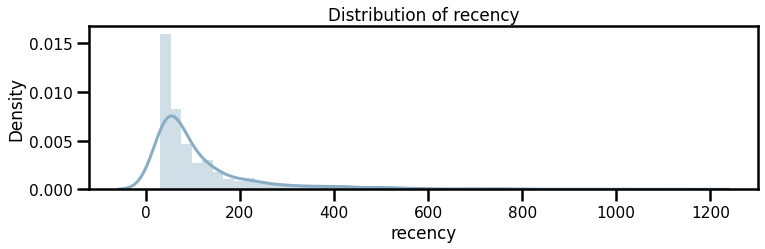

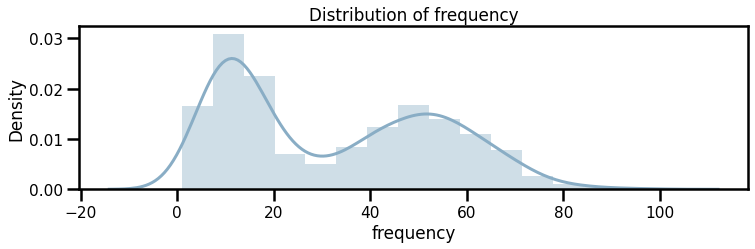

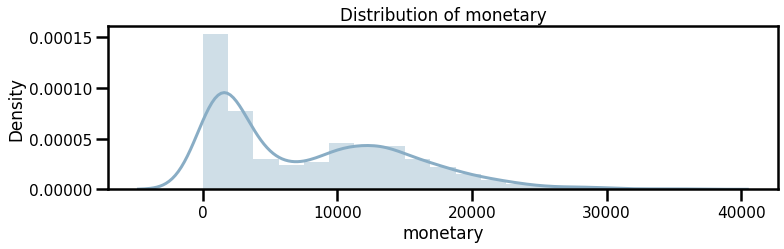

In [79]:
# Visualization for RMF distribution 
colnames = ['recency', 'frequency', 'monetary']

for col in colnames:
    fig, ax = plt.subplots(figsize=(12,3))
    sns.distplot(RMFScore[col])
    ax.set_title('Distribution of %s' % col)
    plt.show()

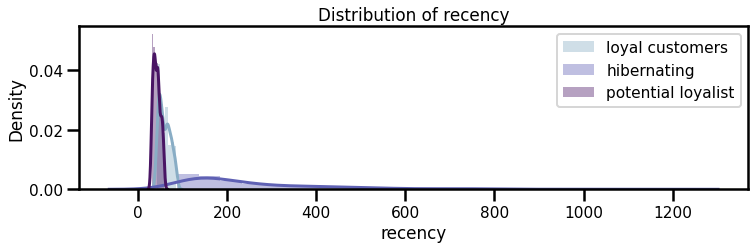

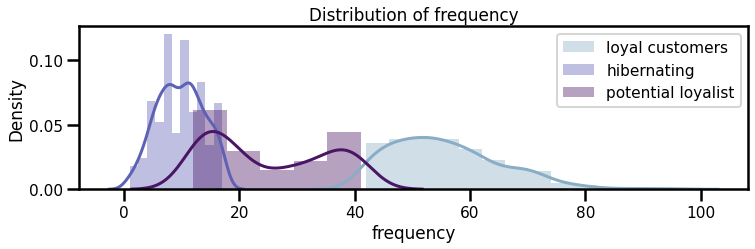

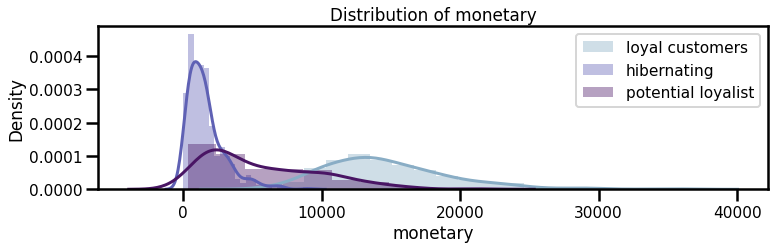

In [80]:
segments = ['loyal customers', 'hibernating', 'potential loyalist']

for col in colnames:
    fig, ax = plt.subplots(figsize=(12,3))
    for segment in segments:
        sns.distplot(RMFScore[RMFScore['rfm_label']==segment][col], label=segment)
    ax.set_title('Distribution of %s' % col)
    plt.legend()
    plt.show()

In [81]:
agg_dict2 = {
    'customer_id': 'count',
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'sum'
}

df_analysis = RMFScore.groupby('rfm_label').agg(agg_dict2).sort_values(by='recency').reset_index()
df_analysis.rename({'rfm_label': 'label', 'customer_id': 'count'}, axis=1, inplace=True)
df_analysis['count_share'] = df_analysis['count'] / df_analysis['count'].sum()
df_analysis['monetary_share'] = df_analysis['monetary'] / df_analysis['monetary'].sum()
df_analysis['monetary'] = df_analysis['monetary'] / df_analysis['count']

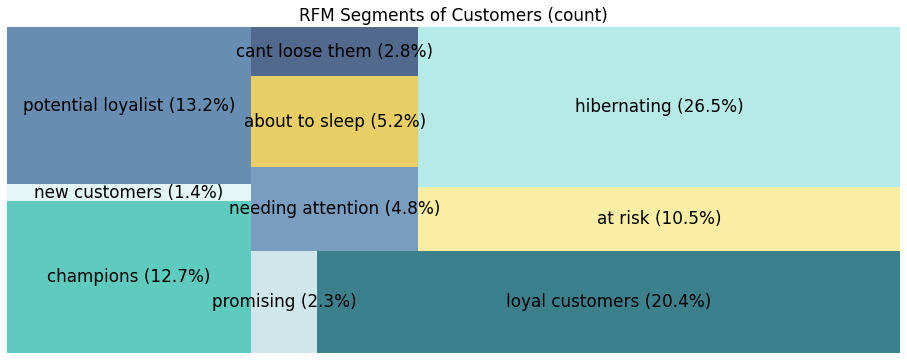

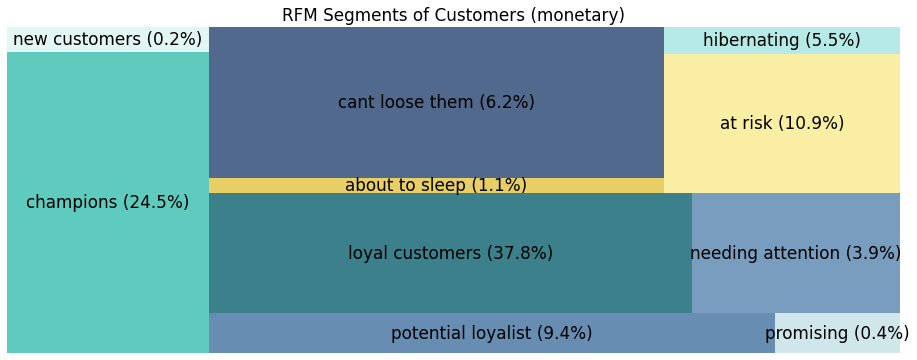

In [83]:
import squarify
colors = ['#37BEB0', '#DBF5F0', '#41729F', '#C3E0E5', '#0C6170', '#5885AF', '#E1C340', '#274472', '#F8EA8C', '#A4E5E0', '#1848A0']

for col in ['count', 'monetary']:
    labels = df_analysis['label'] + df_analysis[col + '_share'].apply(lambda x: ' ({0:.1f}%)'.format(x*100))

    fig, ax = plt.subplots(figsize=(16,6))
    squarify.plot(sizes=df_analysis[col], label=labels, alpha=.8, color=colors)
    ax.set_title('RFM Segments of Customers (%s)' % col)
    plt.axis('off')
    plt.show()

In [84]:
RMFScore=RMFScore.reset_index()

In [87]:
newdata = RMFScore[['recency', 'frequency', 'monetary']]

In [88]:
newdata.head()

,recency,frequency,monetary
0,39,42,"13,747.41"
1,37,42,"5,884.20"
2,148,38,"17,695.59"
3,57,73,"15,343.89"
4,33,8,"2,243.26"


<AxesSubplot:ylabel='monetary'>

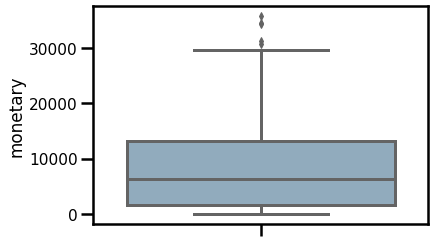

In [90]:
sns.boxplot(y = 'monetary', data=RMFScore)

In [91]:
from sklearn.preprocessing import StandardScaler
scalobj = StandardScaler()
scaled_data = scalobj.fit_transform(newdata)
scaled_data

array([[-0.62278781,  0.44477291,  0.83585653],
       [-0.63843241,  0.44477291, -0.29808887],
       [ 0.22984275,  0.26215472,  1.40521845],
       ...,
       [-0.6618993 ,  2.36226386,  2.95939002],
       [-0.6618993 , -0.65093621, -0.72104888],
       [-0.6775439 ,  0.17084563,  0.22036339]])

In [92]:
scaled_data = pd.DataFrame(scaled_data, columns= newdata.columns)

In [93]:
scaled_data.head()

,recency,frequency,monetary
0,-0.62,0.44,0.84
1,-0.64,0.44,-0.30
2,0.23,0.26,1.41
3,-0.48,1.86,1.07
4,-0.67,-1.11,-0.82


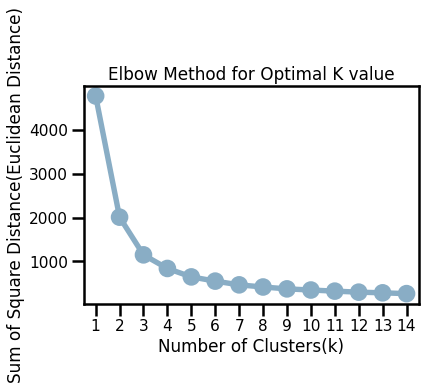

In [94]:
from sklearn.cluster import KMeans

sum_of_sq_dist = {}

for k in range(1,15):
    km = KMeans(n_clusters = k, init='k-means++', max_iter=300)
    km = km.fit(scaled_data)
    sum_of_sq_dist[k] = km.inertia_
    
# Visualisation for getting elbow method (to find the actual k value)

sns.pointplot(x = list(sum_of_sq_dist.keys()),
             y = list(sum_of_sq_dist.values()))
plt.xlabel("Number of Clusters(k)")
plt.ylabel("Sum of Square Distance(Euclidean Distance)")
plt.title("Elbow Method for Optimal K value")
plt.show()

In [95]:
km = KMeans(n_clusters = 4, init='k-means++', max_iter=300)

In [96]:
# Assign each data point to a cluster
y_kmeans = km.fit_predict(newdata)

In [97]:
y_kmeans

array([3, 0, 3, ..., 2, 1, 0])

 Our cluster centers are as follows
[[ 2.68834522 -1.05746308 -0.91958033]
 [-0.45468821  1.40181022  1.55681717]
 [-0.03227958 -0.85120748 -0.81969643]
 [-0.43329464  0.63143882  0.45495622]]


,recency,frequency,monetary
cluster_pred,,,
0,136,136,136
1,293,293,293
2,675,675,675
3,486,486,486


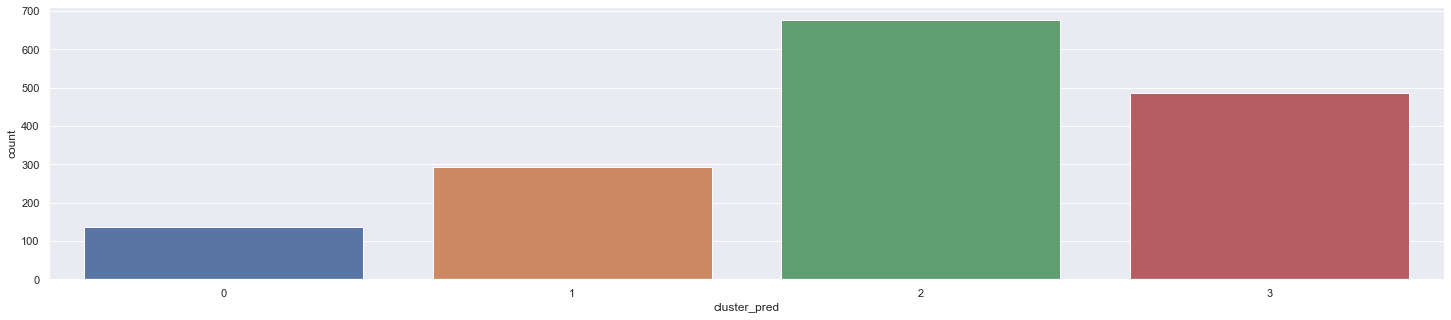

In [98]:
clusters_scaled = newdata.copy()
clusters_scaled['cluster_pred']=km.fit_predict(scaled_data)
sns.set(style="darkgrid")
print(" Our cluster centers are as follows")
print(km.cluster_centers_)
f, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x="cluster_pred", data=clusters_scaled)
clusters_scaled.groupby(['cluster_pred']).count()

In [99]:
RMFScore['Cluster'] = km.labels_
RMFScore.head()

,index,customer_id,frequency,monetary,recency,r_score,f_score,m_score,rfm_sum,rfm_label,Cluster
0,0,AA-10315,42,"13,747.41",39,5,4,4,13,champions,3
1,1,AA-10375,42,"5,884.20",37,5,4,3,12,champions,3
2,2,AA-10480,38,"17,695.59",148,2,3,5,10,at risk,3
3,3,AA-10645,73,"15,343.89",57,4,5,5,14,loyal customers,1
4,4,AA-315,8,"2,243.26",33,5,1,2,8,new customers,2


In [100]:
# look at the centroids per cluster
centroid_df = RMFScore.groupby('Cluster')[['recency', 'frequency', 'monetary','customer_id']].agg({'recency': 'mean', 'frequency': 'mean', 'monetary':'mean','customer_id':'nunique'}).reset_index()
centroid_df = centroid_df.rename(columns = {'customer_id':'NumBuyers'})
centroid_df

,Cluster,recency,frequency,monetary,NumBuyers
0,0,462.29,9.10,"1,574.53",136
1,1,60.59,62.99,"18,759.59",293
2,2,114.49,13.61,"2,267.17",675
3,3,63.16,46.10,"11,114.13",486


In [101]:
centroid_df['Percent'] = round(centroid_df['NumBuyers']/centroid_df.NumBuyers.sum()*100,2)
centroid_df

,Cluster,recency,frequency,monetary,NumBuyers,Percent
0,0,462.29,9.10,"1,574.53",136,8.55
1,1,60.59,62.99,"18,759.59",293,18.43
2,2,114.49,13.61,"2,267.17",675,42.45
3,3,63.16,46.10,"11,114.13",486,30.57
